This code is understand how Naive Bayes is used to generate sentiment analysis. It is then compared to logistic regression. 

In [92]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, "..")


import matplotlib.pyplot as plt
%matplotlib inline

import importlib
importlib.reload(utils)
from src.utils import *

In [5]:
import re, string, collections, bcolz, pickle, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix

In [6]:
reviews_raw = pd.read_csv('../data/metacritic_reviews.csv', lineterminator='\n')

In [7]:
reviews_raw.shape

(127699, 6)

In [8]:
reviews_raw.head()

,score,text,critic,date,title,platform
0,74.0,"it makes a terrible first impression, but ult...",Gaming Nexus,2014-11-18,#KILLALLZOMBIES,PlayStation 4
1,65.0,brings some fresh and inventive ideas to the ...,Playstation Universe,2014-11-17,#KILLALLZOMBIES,PlayStation 4
2,60.0,a fun main mode of play that can get quite add...,Gamers' Temple,2015-02-16,#KILLALLZOMBIES,PlayStation 4
3,60.0,"simply put, feels like half of a game.",DarkStation,2014-12-04,#KILLALLZOMBIES,PlayStation 4
4,60.0,"combined with the price and lack of cross-buy,...",Worth Playing,2014-11-30,#KILLALLZOMBIES,PlayStation 4


In [10]:
reviews = reviews_raw[['score', 'text']]

In [11]:
reviews.head()

,score,text
0,74.0,"it makes a terrible first impression, but ult..."
1,65.0,brings some fresh and inventive ideas to the ...
2,60.0,a fun main mode of play that can get quite add...
3,60.0,"simply put, feels like half of a game."
4,60.0,"combined with the price and lack of cross-buy,..."


## Previous person split into most polarizing here. Would be interesting to split differently

In [15]:
print("Reviews with scores greater than 85: {}".format(len(reviews.loc[reviews["score"] > 85])))
print("Reviews with scores less than 50: {}".format(len(reviews.loc[reviews["score"] < 50])))

Reviews with scores greater than 85: 43518
Reviews with scores less than 50: 20428


In [28]:
pos = reviews.loc[reviews['score'] > 85, 'text'].copy().reset_index(drop=True)
neg = reviews.loc[reviews['score'] < 50, 'text'].copy().reset_index(drop=True)

In [19]:
print("Number of datasets for postive: {} and negative: {}.".format(len(pos), len(neg)))

Number of datasets for postive: 43518 and negative: 20428.


## Investigate postive and negative reviews

In [25]:
print("Postiive Reviews: ")
print("\n")
for i in range(4):
    print("".join(pos[np.random.randint(0, len(pos))]))
    print("\n")

Postiive Reviews: 


i can't stop playing this game! i've been playing forza games for years now and this is the best one yet (besides forza: horizon 2). the rain is amazing and super fun, the new champaign mode is really good and the cars and tracks are flawless. the only thing i can think they could improve on in the balance of hitting other cars in multiplayer. it's really frustrating when you are about to finish a race in 1st place and then a car behind you decides not to brake on a turn and hits you from behind, launching you into the wall forcing you to finish in last place. overall this is a practically flawless racing game.


amazing graphics, amazing story, action packed drama with the best treasure hunt in the series, naughty dog never disappoints.


an outstanding masterpiece. it is easy to see why this was nominated for game of the year, this game just has so much right with it from story and characters to the most fun i have ever had with a turn based combat system and the

In [24]:
print("Negative Reviews: ")
print("\n")

for i in range(4):
    print("".join(neg[np.random.randint(0, len(neg))]))
    print("\n")

Negative Reviews: 


 terrible filler and terrible company that puts out such trash and wastes my good money on a wall running demo.


 is perfect for those who take pride in their gamerscore and are always looking to increase their number of achievements. the game hands out achievements as frequently as parents hand out candy on halloween night. those looking for something a bit more than gamerscore in a game might want to look elsewhere as there is little in  that is particularly new or fun.


old school to a fault, the worst thing about this japanese role-player is it doesn’t seem to have any idea just how clichéd and outdated it really is.


requires too much effort and time to finish. there is no difficulty option. overrated game




### Add labels

In [29]:
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(pos.shape), columns = ['class'])], 1)
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns = ['class'])], 1)

In [30]:
## Summary stats of Positive

In [40]:
lengthsP = pos['text'].str.len()
lengthsP.mean(), lengthsP.std(), lengthsP.max()

(586.1869801001884, 738.0401469961486, 25554)

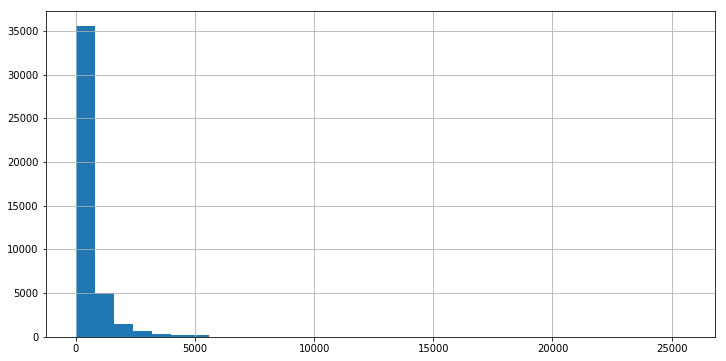

In [41]:
lengthsP.hist(figsize = (12,6), bins = 32)

In [42]:
lengthsN = neg['text'].str.len()
lengthsN.mean(), lengthsN.std(), lengthsN.max()

(681.7165654983356, 823.7599066187882, 14736)

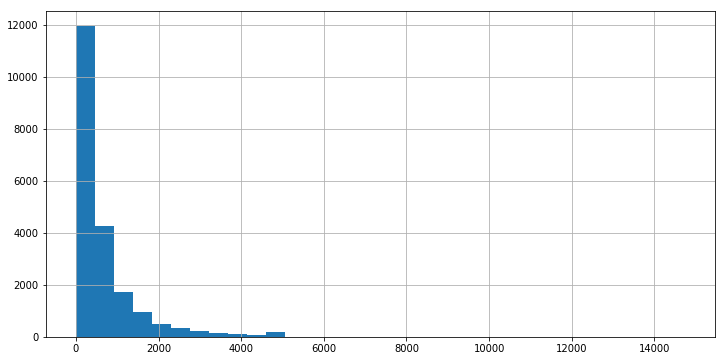

In [43]:
lengthsN.hist(figsize = (12,6), bins = 32)

In [44]:
## Balanced dataset of positive and negative instances

In [45]:
np.random.seed(30)
rand = np.random.permutation(pos.shape[0])

In [47]:
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)

In [48]:
neg.shape, pos.shape

((20428, 2), (20428, 2))

In [49]:
reviews = pd.concat([pos,neg]).sample(frac=1).reset_index(drop=True) ## randomly resample 

In [50]:
reviews.head()

,text,class
0,"gorgeous looking game, other than zelda this i...",1.0
1,i have tried to play this game several times w...,0.0
2,learning from the mistakes of the original ver...,1.0
3,i thought a lot to find a disadvantage for thi...,1.0
4,"it's good, but could have been more. bfh defin...",0.0


In [51]:
reviews.shape

(40856, 2)

### Split out data into train and test set

In [54]:
X_train, X_test, y_train, y_test = train_test_split(reviews['text'].values, 
                                                    reviews['class'].values,
                                                    test_size = 0.2,
                                                    random_state = 30
                                                   )

In [60]:
len(X_train), len(X_test), len(y_train), len(y_test)

(32684, 8172, 32684, 8172)

In [64]:
## Tokenize

In [65]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [66]:
## Create bag of words

In [68]:
vect = CountVectorizer(tokenizer = tokenize)

In [70]:
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [77]:
tf_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       ...,
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]], dtype=int64)

In [83]:
vect.get_feature_names()[10000]

'currant'

In [84]:
vocab = vect.get_feature_names()

In [85]:
len(vocab)

45132

## Multinomial Navie Bayes

Use truncated SVD rather than PCA because we are working with sparse matrices and then plot in order to see how classes are seperated

In [127]:
from sklearn.decomposition import NMF

In [138]:
nmf = NMF(n_components=2)
reduced_tf_train = nmf.fit_transform(tf_train)

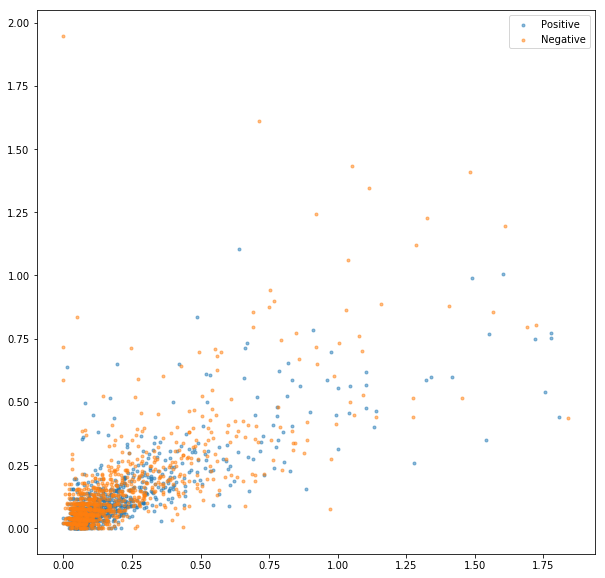

In [139]:
plot_embeddings(reduced_tf_train, y_train)

In [140]:
tf_train

array([[1.27945025, 0.25920642],
       [0.18531092, 0.03250008],
       [0.12867322, 0.03591227],
       ...,
       [0.09864261, 0.07732282],
       [0.33975132, 0.20929504],
       [0.3093269 , 0.06786586]])

In [141]:
from sklearn.naive_bayes import MultinomialNB

In [148]:
clf = MultinomialNB()
clf.fit(tf_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [149]:
y_predicted = clf.predict(tf_test)

In [150]:
from sklearn import metrics

In [151]:
print(metrics.classification_report(y_test, 
                                    y_predicted
                                   ))

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      4062
         1.0       0.90      0.92      0.91      4110

   micro avg       0.91      0.91      0.91      8172
   macro avg       0.91      0.91      0.91      8172
weighted avg       0.91      0.91      0.91      8172



In [152]:
metrics.confusion_matrix(y_test, 
                        y_predicted)

array([[3643,  419],
       [ 340, 3770]], dtype=int64)

In [153]:
from sklearn.linear_model import LogisticRegression

In [154]:
lg = LogisticRegression(random_state = 0)

In [156]:
lg.fit(tf_train, y_train)

C:\Users\rhall\AppData\Local\Continuum\anaconda3\envs\vari\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [157]:
y_predicted_lg = lg.predict(tf_test)

In [158]:
print(metrics.classification_report(y_test, 
                                    y_predicted_lg
                                   ))

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      4062
         1.0       0.93      0.93      0.93      4110

   micro avg       0.93      0.93      0.93      8172
   macro avg       0.93      0.93      0.93      8172
weighted avg       0.93      0.93      0.93      8172



In [159]:
coef_df = pd.DataFrame({'vocab': vocab, 'coef':lg.coef_.reshape(-1)})
pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

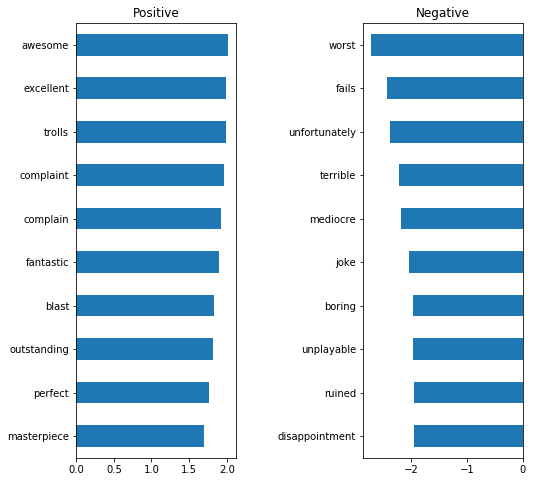

In [160]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');

In [161]:
## Switch to bigram tf-idf

In [162]:
vect = TfidfVectorizer(strip_accents='unicode', 
                       tokenizer=tokenize, 
                       ngram_range=(1, 2), 
                       max_df=0.9, 
                       min_df=3, 
                       sublinear_tf=True)

In [163]:
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

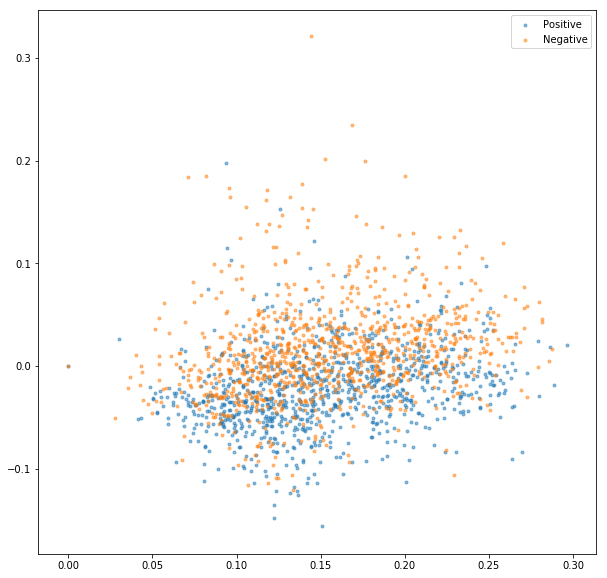

In [166]:
svd = TruncatedSVD()
reduced_tfidf_train = svd.fit_transform(tfidf_train)
plot_embeddings(reduced_tfidf_train, y_train)

In [168]:
lg = LogisticRegression(random_state = 0)
lg.fit(tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [171]:
y_predicted_lg = lg.predict(tfidf_test)

In [172]:
print(metrics.classification_report(y_test, 
                                    y_predicted_lg
                                   ))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      4062
         1.0       0.95      0.94      0.94      4110

   micro avg       0.94      0.94      0.94      8172
   macro avg       0.94      0.94      0.94      8172
weighted avg       0.94      0.94      0.94      8172



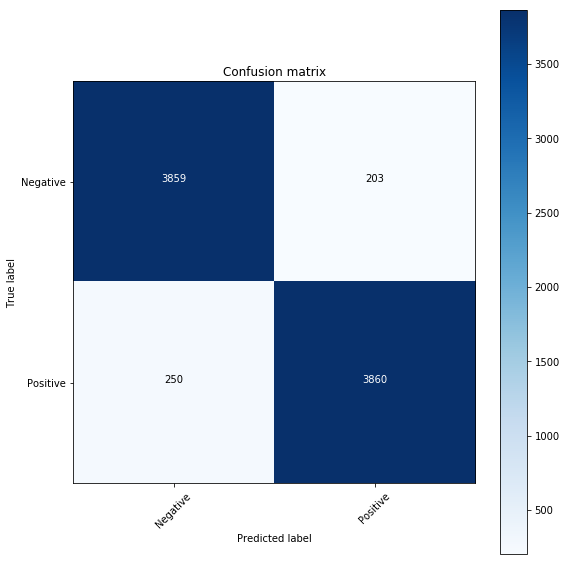

In [173]:
plot_confusion_matrix(confusion_matrix(y_test, y_predicted_lg.T), classes=['Negative', 'Positive'], title='Confusion matrix')